## Notes
* This notebook has implementations of spike backprop for spike vectors collected from `SPIKEFLOW` of `EMNIST` data.Only `Spike backprop` section is implemented and `feedback alignment (Section 6)` (random backprop) and `feedforward (Section 7)` are presented here just for the code but not used. In this case we code backprop using the final update equations. Here we used `tf.data` API. This notebook also has the accuracy cases where some of the label pairs like `f-F`, `0-O`, `q-9`, `1,I,L`, `S,5` and `2,Z` are collapsed into one labels. We also test this network for the case where labels are conditioned, i.e, if the label is an `upper case` or a `lower case` or a `numeric`. Here we use surrogate gradients.  We also apply `tf.floor` function to the `z_3` for easy evaluation of softmax activations in hardware.

* Here, error in the hidden layer, $\delta^{2}$ is implemented as:
$ \delta^{2} = W^{3T}\delta^{(3)}\odot\sigma^{'}(z^{(2)}) \tag{1}$
*  Make sure `heat_map_data.sum(axis=1)`
## References
* [Neural Nets](http://neuralnetworksanddeeplearning.com/chap3.html)
* [Randombackprop](https://github.com/xuexue/randombp/blob/master/randombp.py)
* [Randombackprop](https://github.com/sangyi92/feedback_alignment/blob/master/RFA.ipynb)
* [Backprop](http://blog.aloni.org/posts/backprop-with-tensorflow/)
* [Initializers](https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404)
* [Dropout](https://github.com/pinae/TensorFlow-MNIST-example/blob/master/fully-connected.py)
* [Softmax](https://stackoverflow.com/questions/34240703/what-is-logits-softmax-and-softmax-cross-entropy-with-logits)
* [SoftmaxLogits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)

In [1]:
%matplotlib notebook
import os, time
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from IPython.display import display, HTML
tf.compat.v2.random.set_seed(0)
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.client import timeline
import h5py, pickle
from keras.utils.np_utils import to_categorical 
import numpy as np
import theano, random, sys, time
import seaborn as sb
import pandas as pd
##%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
tf

1.14.0


<module 'tensorflow' from '/home/ruthvik/.local/lib/python2.7/site-packages/tensorflow/__init__.pyc'>

## Restart kernel

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

## Hide code

In [ ]:
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 15,10
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 25

## Load data

In [4]:
filename = '../outputs/journal_resubmit/train_emnist_rndm_spike_features_floats'+'.h5'
with h5py.File(filename, 'r') as hf:
    emnist_train_images = hf['pool1_spike_features'][0].astype(np.int8)
emnist_train_images[np.where(emnist_train_images>=1)] = 1
print('Total train features:{}'.format(emnist_train_images.shape[0]))


filename = '../outputs/journal_resubmit/test_emnist_rndm_spike_features_floats'+'.h5'
with h5py.File(filename, 'r') as hf:
    emnist_test_images = hf['pool1_spike_features'][0].astype(np.int8)
emnist_test_images[np.where(emnist_test_images>=1)] = 1
print('test features:{}'.format(emnist_test_images.shape[0]))


filename = '../outputs/journal_resubmit/train_emnist_rndm_spike_feature_labels_floats'+'.h5'
with h5py.File(filename, 'r') as hf:
    emnist_train_labels = hf['pool1_spike_feature_labels'][0].astype(np.int8)
emnist_train_labels = to_categorical(emnist_train_labels, num_classes=47)


filename = '../outputs/journal_resubmit/test_emnist_rndm_spike_feature_labels_floats'+'.h5'
with h5py.File(filename, 'r') as hf:
    emnist_test_labels = hf['pool1_spike_feature_labels'][0].astype(np.int8)
emnist_test_labels = to_categorical(emnist_test_labels, num_classes=47)

print('Length of test labels:{}'.format(emnist_test_labels.shape[0]))
n_images = len(emnist_train_images)


emnist_valid_images = emnist_train_images[0:int(0.09*n_images)]
print('Length of valid images:{}'.format(emnist_valid_images.shape[0]))
emnist_train_images = emnist_train_images[int(0.09*n_images):]
print('Length of train images:{}'.format(emnist_train_images.shape[0]))


emnist_valid_labels = emnist_train_labels[0:int(0.09*n_images)]
print('Length of valid labels:{}'.format(emnist_valid_labels.shape[0]))
emnist_train_labels = emnist_train_labels[int(0.09*n_images):]
print('Length of train labels:{}'.format(emnist_train_labels.shape[0]))
n_train = emnist_train_labels.shape[0]
n_test = emnist_test_labels.shape[0]
n_valid = emnist_valid_labels.shape[0]

all_train_images = emnist_train_images
all_train_labels = emnist_train_labels

Total train features:112798
test features:18800
Length of test labels:18800
Length of valid images:10151
Length of train images:102647
Length of valid labels:10151
Length of train labels:102647


In [5]:
BATCH_SIZE = 5
epochs = 30
emnist_train_images = np.array_split(emnist_train_images, n_train/(BATCH_SIZE))
emnist_train_labels = np.array_split(emnist_train_labels, n_train/(BATCH_SIZE))
train_data = zip(emnist_train_images,emnist_train_labels)
print('Total number of epochs:{}'.format(epochs))
n_batches = len(train_data)
print('Number of batches in an epoch:{}'.format(n_batches))

Total number of epochs:30
Number of batches in an epoch:20529


## Spike backprop

In [6]:
#sess.close()
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess= tf.InteractiveSession(config=config)
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

$tanh(x) = \frac{(e^{x} – e^{-x})}{(e^{x} + e^{-x})}$

$d\frac{tanh(x)}{dx} = 1 – (tanh(x))^{2}$

$\sigma(x) = \frac{1.0}{1 + e^{-x}}$

$d\frac{\sigma(x)}{dx} = \sigma(x)*(1 - \sigma(x))$

### Network Setup

In [7]:
n_input = 3630
n_middle = 1500
n_out = 47
batch_size = tf.placeholder(tf.int64, name='batch_size') 
a_1 = tf.placeholder(tf.float32, [None, n_input], name = 'Input_batch')
y = tf.placeholder(tf.float32, [None, n_out], name = 'output_batch')
dataset = tf.data.Dataset.from_tensor_slices((a_1, y))
#dataset = dataset.shuffle(buffer_size=len(all_train_labels), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size)
iter = dataset.make_initializable_iterator()
features, labels = iter.get_next()

tau = tf.placeholder(tf.float32, name='tau')
drop_out = tf.placeholder(tf.float32, name='drop_out')
with tf.name_scope('hid_lyr_w_b'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(n_input + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_input + n_middle))
    
    low = -tf.math.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
    high = tf.math.sqrt(2.0/(n_input))
    
    #w_2 = tf.Variable(tf.random_uniform(shape=[n_input,n_middle],minval=low,maxval=high), name = 'W_2')
    w_2 = tf.Variable(tf.truncated_normal(shape=[n_input,n_middle], stddev=0.01),name = 'W_2')
    tf.summary.histogram('w_2', w_2)
    b_2 = tf.Variable(tf.zeros([1,n_middle]), name = 'b_2')
    tf.summary.histogram('b_2', b_2)
with tf.name_scope('op_lyr_w_b'):
    
    low = -tf.math.sqrt(2.0/(n_middle))
    high = tf.math.sqrt(2.0/(n_middle))
    #w_3 = tf.Variable(tf.random_uniform(shape=[n_middle,10],minval=low,maxval=high), name = 'W_3')
    w_3 = tf.Variable(tf.truncated_normal(shape=[n_middle,n_out], stddev=0.01),name = 'W_3')
    tf.summary.histogram('w_3', w_3)
    b_3 = tf.Variable(tf.zeros([1,n_out]), name = 'b_3')
    tf.summary.histogram('b_3', b_3)

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))

def spkNeuron(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))
def firstLyrSpks(x):
    return tf.where(tf.greater_equal(x,1.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def ReLU(x):
    return tf.maximum(0.0, x)

def ReLUprime(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))
def spkPrime2(x):
    l1_bound_greater = tf.greater_equal(x,-tau/4)
    l1_bound_lesser = tf.less_equal(x,-tau/4)
    
    r1_bound_lesser = tf.less_equal(x,tau/4)
    r1_bound_greater = tf.greater_equal(x,tau/4)
    
    l2_bound_greater = tf.greater_equal(x,-tau/2)
    r2_bound_lesser = tf.less_equal(x,tau/2)
    
    grad_one = tf.where(tf.logical_and(l1_bound_greater,r1_bound_lesser), tf.ones_like(x), tf.zeros_like(x))
    
    left_log_and = tf.logical_and(l2_bound_greater,l1_bound_lesser)
    right_log_and = tf.logical_and(r2_bound_lesser, r1_bound_greater)
    
    grad_two = tf.where(tf.logical_or(left_log_and,right_log_and),0.5*tf.ones_like(x), tf.zeros_like(x))
    
    return tf.add(grad_one, grad_two)

def spkPrime3(x):
    l1_bound_greater = tf.greater_equal(x,-tau/4)
    l1_bound_lesser = tf.less_equal(x,-tau/4)
    
    r1_bound_lesser = tf.less_equal(x,tau/4)
    r1_bound_greater = tf.greater_equal(x,tau/4)
    
    l2_bound_greater = tf.greater_equal(x,-tau/3)
    l2_bound_lower = tf.less_equal(x,-tau/3)
    
    r2_bound_lesser = tf.less_equal(x,tau/3)
    r2_bound_greater = tf.greater_equal(x,tau/3)
    
    
    l3_bound_greater = tf.greater_equal(x,-tau/2)
    r3_bound_lesser = tf.less_equal(x,tau/2)
    
    grad_one = tf.where(tf.logical_and(l1_bound_greater,r1_bound_lesser), tf.ones_like(x), tf.zeros_like(x))
    
    left_log_and1 = tf.logical_and(l1_bound_lesser,l2_bound_greater)
    right_log_and1 = tf.logical_and(r2_bound_lesser, r1_bound_greater)
    
    grad_two = tf.where(tf.logical_or(left_log_and1,right_log_and1),0.5*tf.ones_like(x), tf.zeros_like(x))
    
    left_log_and2 = tf.logical_and(l3_bound_greater,l2_bound_lower)
    right_log_and2 = tf.logical_and(r3_bound_lesser, r2_bound_greater)
    
    grad_three = tf.where(tf.logical_or(left_log_and1,right_log_and1),0.25*tf.ones_like(x), tf.zeros_like(x))
    
    return tf.add_n([grad_one, grad_two, grad_three])


def spkPrime1(x):
    l1_bound_higher = tf.greater_equal(x,-0/4)
    #l1_bound_lower = tf.less_equal(x,-tau/4)
    
    r1_bound_lesser = tf.less_equal(x,tau/4)
    #r1_bound_greater = tf.greater_equal(x,tau/4)
    
    #l2_bound_greater = tf.greater_equal(x,-tau/2)
    #r2_bound_lesser = tf.less_equal(x,tau/2)
    
    grad_one = tf.where(tf.logical_and(l1_bound_higher,r1_bound_lesser), tf.ones_like(x), tf.zeros_like(x))
    
    #left_log_and = tf.logical_and(l1_bound_higher,l1_bound_lower)
    #right_log_and = tf.logical_and(r2_bound_lesser, r1_bound_greater)
    
    #grad_two = tf.where(tf.logical_or(left_log_and,right_log_and),0.5*tf.ones_like(x), tf.zeros_like(x))
    
    return grad_one

with tf.name_scope('hid_lyr_acti'):
    z_2 = tf.add(tf.matmul(features,w_2,name = 'w_2xa_1'), b_2, name = 'z_2')
    locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]), tf.size(z_2))
    #locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]),n_middle*batch_size )
    #locs_to_drop = tf.reshape(locs_to_drop, z_2.shape)
    #locs_to_drop = tf.reshape(locs_to_drop, [n_middle,batch_size])
    locs_to_drop = tf.reshape(locs_to_drop, tf.shape(z_2))
    z_2 = tf.where(locs_to_drop>0,-tf.ones_like(z_2),z_2, 'drop_out_app')
    tf.summary.histogram('z_2', z_2)
    a_2 = spkNeuron(z_2)
    tf.summary.histogram('a_2', a_2)
with tf.name_scope('op_lyr_acti'):
    z_3 = tf.add(tf.matmul(a_2,w_3, name = 'w_3xa_2'),b_3, name = 'z_3')
    z_3 = tf.floor(z_3)
    tf.summary.histogram('z_3', z_3)
    #a_3  = spkNeuron(z_3) ##UNCOMMENT THIS LINE AND COMMENT ABOVE LINE IF YOU WANT spike SQUISHING
    ##COMMENT THE ABOVE LINE AND UNCOMMENT BELOW LINE IF YOU WANT SOFTMAX
    a_3 = tf.nn.softmax(z_3,axis=1) ##AXIS IS VERY IMPORTANT!!! axis=1 INDICATES THE CLASSES AS y IS [None,10]

#cost = tf.reduce_mean(-tf.reduce_sum(tf.multiply(a_3,tf.log(y)),axis=0), name = 'cost_calc') GIVES inf COST!!!
#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
with tf.name_scope('cost_calc'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,logits=z_3,axis=1),name = 'cost_calc')#WORKS
    ##COMMENT BELOW LINES IF YOU WANT SOFTMAX
    #dc_da = -tf.subtract(labels,a_3, name = 'y_minus_a_3')
    #cost = tf.reduce_mean(tf.reduce_sum((1/2.0)*tf.square(dc_da),axis=1), name = 'cost_calc')
    tf.summary.scalar('cost', cost)

with tf.name_scope('op_lyr_grad'):
    d_z_3 = -tf.subtract(labels,a_3, name = 'delta3')
    #d_z_3 = tf.multiply(dc_da,a_3, name = 'delta3')
    d_b_3 = d_z_3
    tf.summary.histogram('d_b_3', d_b_3)
    d_w_3 = tf.matmul(tf.transpose(a_2),d_z_3, name='delta_w3')
    tf.summary.histogram('d_w_3', d_w_3)
    
with tf.name_scope('hid_lyr_grad'):
    d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3), name = 'w_3Txdelta3'), spkPrime1(z_2), name = 'delta2')
    #d_z_2 = tf.matmul(d_z_3,tf.transpose(w_3), name = 'delta2')
    d_b_2 = d_z_2
    tf.summary.histogram('d_b_2', d_b_2)
    d_w_2 = tf.matmul(tf.transpose(features),d_z_2, name = 'delta_w2')
    tf.summary.histogram('d_w_2', d_w_2)
    
eta = tf.constant(0.02)
step = [
    tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta/tf.cast(batch_size, tf.float32), d_w_2)))
  , tf.assign(b_2,
            tf.subtract(b_2, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_2, axis=[0]),axis=0))))
  , tf.assign(w_3,
            tf.subtract(w_3, tf.multiply(eta/tf.cast(batch_size, tf.float32), d_w_3)))
  , tf.assign(b_3,
            tf.subtract(b_3, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_3, axis=[0]),axis=0))))
]

with tf.name_scope('acc_calc'):   
    predictions = tf.argmax(a_3, 1)
    acct_mat = tf.equal(tf.argmax(a_3, 1), tf.argmax(labels, 1))
    acct_res = tf.reduce_mean(tf.cast(acct_mat, tf.float32))
    tf.summary.scalar('accuracy', acct_res)

path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/emnist/v8'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/train', sess.graph)
valid_writer = tf.summary.FileWriter(path + '/valid')

init_op = tf.global_variables_initializer()


### Commence training

In [8]:
epochs = 35
repeats = 5
all_best_val_accs = []
all_best_test_accs = []
all_final_test_accs = []

for repeat in range(repeats):
    print('Repeat:{}'.format(repeat))
    tf.set_random_seed(10*(repeat+1))
   
    sess.run(init_op,options=run_options, run_metadata=run_metadata)
    train_accuracies = []
    train_costs = []
    val_accuracies = []
    val_costs = []
    best_val = 0
    best_params = None
    logging_count = 0
    best_predictions = None ##for valid data
    best_predictions_test = None
    predictions_test = None
    best_classifications = None
    best_activations = None ##for valid data
    best_activations_test = None
    activations_test = None

    T1 = time.time()
    for i in range(epochs):

        sess.run(iter.initializer, feed_dict={ a_1: all_train_images, y: all_train_labels,
                                              batch_size: len(all_train_images)})
        print('Epoch:{}'.format((i)))
        t1 = time.time()

        ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
        ## train cost
        #summary, train_cost = sess.run([merged,cost], feed_dict = {a_1 : all_train_images.transpose(),
        #                                            y : all_train_labels.transpose()})
        #train_writer.add_summary(summary,i)  OOM ERROR
        #train_cost, train_accuracy = sess.run([cost,acct_res] ,feed_dict = {drop_out : 0.0 ,a_1: all_train_images, 
        #                                      y: all_train_labels,batch_size: len(all_train_images)})
        train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0})
        train_costs.append(train_cost)
        train_accuracies.append(train_accuracy)
        #train_writer.add_summary(summary,logging_count)

        print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

        ### CALCULATE VALID COSTS AND VALID ACCURACIES
        sess.run(iter.initializer, feed_dict={ a_1: emnist_valid_images, y: emnist_valid_labels,
                                              batch_size: len(emnist_valid_images)})
        ## valid cost
        #summary, val_cost, val_acc = sess.run([merged,cost,acct_res], feed_dict = {drop_out : 0.0, a_1: emnist_valid_images, 
        #                                            y: emnist_valid_labels,batch_size: len(emnist_valid_images)} )
        all_predictions, classifications, val_acc, val_cost, activ = sess.run([predictions, 
                                                                                        acct_mat, 
                                                                                        acct_res, cost, a_3], 
                                                                             feed_dict = {drop_out : 0.0})
        val_costs.append(val_cost)
        val_accuracies.append(val_acc)
        #valid_writer.add_summary(summary,i)

        if(val_acc>best_val):
            best_val = val_acc
            best_params = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
            best_predictions = all_predictions
            best_classifications = classifications
            best_activations = activ

        print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   

        sess.run(iter.initializer, feed_dict={a_1: all_train_images, y: all_train_labels,
                                              batch_size: BATCH_SIZE})


        for j in range(n_batches):

            if(((j+1)% 5000 ==0)):
                logging_count+=1
                summary,_ = sess.run([merged,step], feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE, tau:0.5})
                #train_writer.add_summary(summary, (i+1)*j)
                train_writer.add_summary(summary, logging_count)
            else:
                sess.run(step, feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE, tau:0.5})
        print('Epoch time:{}'.format(time.time()-t1))

        #logging_count+=1

    sess.run(iter.initializer, feed_dict={ a_1: emnist_test_images, y: emnist_test_labels,
                                              batch_size: len(emnist_test_images)})
    predictions_test,test_acc,activations_test = sess.run([predictions, acct_res, a_3], feed_dict = {drop_out:0.0})


    print('Final test accuracy is:{}'.format(test_acc))
    all_final_test_accs.append(test_acc)

    best_step = [tf.assign(w_2,best_params[0][0]), tf.assign(b_2,best_params[0][1]),tf.assign(w_3,best_params[1][0]),\
        tf.assign(b_3,best_params[1][1])]

    sess.run(best_step)
    sess.run(iter.initializer, feed_dict={a_1: emnist_test_images, y: emnist_test_labels,
                                              batch_size: len(emnist_test_images)})
    best_predictions_test,test_acc,best_activations_test = sess.run([predictions, acct_res, a_3], 
                                                                    feed_dict = {drop_out:0.0})


    print('Test accuracy corresp to best val acc:{}'.format(test_acc))
    print('Time taken:{}'.format(time.time()-T1))
    train_writer.close()
    valid_writer.close()
    
    all_best_test_accs.append(test_acc)
    all_best_val_accs.append(max(val_accuracies))
    #tf.reset_default_graph()


Repeat:0
Epoch:0
training cost:3.96564126015 and training accuracy:0.0223581790924
validation cost:3.96927642822 and validation accuracy:0.0239385273308
Epoch time:84.4971389771
Epoch:1
training cost:0.55051702261 and training accuracy:0.822868645191
validation cost:0.768776893616 and validation accuracy:0.753423333168
Epoch time:81.8857569695
Epoch:2
training cost:0.351923406124 and training accuracy:0.885159790516
validation cost:0.723590791225 and validation accuracy:0.767609119415
Epoch time:80.8838579655
Epoch:3
training cost:0.231526777148 and training accuracy:0.925433754921
validation cost:0.718414843082 and validation accuracy:0.77608114481
Epoch time:79.3564190865
Epoch:4
training cost:0.158608019352 and training accuracy:0.950841248035
validation cost:0.740679085255 and validation accuracy:0.775293052197
Epoch time:78.7174561024
Epoch:5
training cost:0.108845964074 and training accuracy:0.968094527721
validation cost:0.767967820168 and validation accuracy:0.783371090889
Epoc

/home/ruthvik/.local/lib/python2.7/site-packages/tensorflow/python/summary/writer/writer.py:386: UserWarning: Attempting to use a closed FileWriter. The operation will be a noop unless the FileWriter is explicitly reopened.
  warnings.warn("Attempting to use a closed FileWriter. "


Epoch time:78.7878639698
Epoch:1
training cost:0.547285914421 and training accuracy:0.825489282608
validation cost:0.766697049141 and validation accuracy:0.752438187599
Epoch time:78.8536748886
Epoch:2
training cost:0.346750795841 and training accuracy:0.88877415657
validation cost:0.711444973946 and validation accuracy:0.771943628788
Epoch time:79.045566082
Epoch:3
training cost:0.234895288944 and training accuracy:0.923592507839
validation cost:0.715840101242 and validation accuracy:0.773421347141
Epoch time:79.3477339745
Epoch:4
training cost:0.160832315683 and training accuracy:0.949360430241
validation cost:0.746520578861 and validation accuracy:0.772337675095
Epoch time:78.7942199707
Epoch:5
training cost:0.114003784955 and training accuracy:0.965025782585
validation cost:0.774305045605 and validation accuracy:0.778839528561
Epoch time:78.7537479401
Epoch:6
training cost:0.0841912254691 and training accuracy:0.975712895393
validation cost:0.81844574213 and validation accuracy:0.7

validation cost:0.923421084881 and validation accuracy:0.779923141003
Epoch time:78.7954690456
Epoch:14
training cost:0.0151277268305 and training accuracy:0.997681379318
validation cost:0.93223631382 and validation accuracy:0.780415713787
Epoch time:78.9010410309
Epoch:15
training cost:0.012670240365 and training accuracy:0.998480200768
validation cost:0.940756976604 and validation accuracy:0.783765137196
Epoch time:79.2418868542
Epoch:16
training cost:0.0122839529067 and training accuracy:0.998158752918
validation cost:0.952862918377 and validation accuracy:0.782681524754
Epoch time:79.1444292068
Epoch:17
training cost:0.0105117084458 and training accuracy:0.998772501945
validation cost:0.960177481174 and validation accuracy:0.781105339527
Epoch time:79.192838192
Epoch:18
training cost:0.00881469342858 and training accuracy:0.999240100384
validation cost:0.969187796116 and validation accuracy:0.781499385834
Epoch time:78.9321818352
Epoch:19
training cost:0.00821504089981 and training

Epoch time:78.6439590454
Epoch:26
training cost:0.00497438851744 and training accuracy:0.99974668026
validation cost:1.00549185276 and validation accuracy:0.786424994469
Epoch time:82.0089888573
Epoch:27
training cost:0.00465102819726 and training accuracy:0.999844133854
validation cost:1.01989972591 and validation accuracy:0.784750282764
Epoch time:81.0992560387
Epoch:28
training cost:0.00444816565141 and training accuracy:0.999834358692
validation cost:1.01634907722 and validation accuracy:0.78612947464
Epoch time:79.6099030972
Epoch:29
training cost:0.00422641308978 and training accuracy:0.999892830849
validation cost:1.02117979527 and validation accuracy:0.783765137196
Epoch time:79.3331589699
Epoch:30
training cost:0.00408705649897 and training accuracy:0.999844133854
validation cost:1.02616429329 and validation accuracy:0.784060657024
Epoch time:78.7437632084
Epoch:31
training cost:0.00383223406971 and training accuracy:0.999814927578
validation cost:1.03026866913 and validation 

### Inspecting mis classified samples

In [9]:
all_best_val_accs = np.array(all_best_val_accs)
print('best validation:{}, mean validation:{}, std validation:{}'.format(all_best_val_accs.max(),
                                                                        all_best_val_accs.mean(),
                                                                         all_best_val_accs.std()))
all_best_test_accs = np.array(all_best_test_accs)
print('best test:{}, mean test:{}, std test:{}'.format(all_best_test_accs.max(),
                                                                        all_best_test_accs.mean(),
                                                                         all_best_test_accs.std()))

all_final_test_accs = np.array(all_final_test_accs)
print('best final test:{}, mean final test:{}, std final test:{}'.format(all_final_test_accs.max(),
                                                                        all_final_test_accs.mean(),
                                                                         all_final_test_accs.std()))

best validation:0.786424994469, mean validation:0.784947276115, std validation:0.00152995879762
best test:0.788563847542, mean test:0.787276625633, std test:0.00106191355735
best final test:0.790691494942, mean final test:0.787893652916, std final test:0.00165820971597


In [10]:
right_classify_indices = np.where(best_classifications==True)[0].tolist()
wrong_classify_indices = np.where(best_classifications==False)[0].tolist()
right_predict_labels = best_predictions[np.array(best_classifications)]
wrong_predict_labels = best_predictions[~np.array(best_classifications)]

print(len(right_classify_indices))
print(len(wrong_classify_indices))

right_classify_indices[0:10]

7967
2184


[1, 2, 3, 4, 6, 8, 9, 11, 12, 13]

In [11]:
labels_map = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',
              16:'G',17:'H',18:'I',19:'J',20:'K',21:'L',22:'M',23:'N',24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',30:'U',
             31:'V',32:'W',33:'X',34:'Y',35:'Z',36:'a',37:'b',38:'d',39:'e',40:'f',41:'g',42:'h',43:'n',44:'q',45:'r',
             46:'t'}

In [12]:
original_valid_labels_scalar = emnist_valid_labels.argmax(axis=1)
correct_preds = 0
samples_per_class = [0]*47
correct_classifications_per_class = [0]*47
heat_map_data = np.zeros((47,47))
for i in range(len(original_valid_labels_scalar)):
    true_label = original_valid_labels_scalar[i]
    samples_per_class[true_label]+=1.0
    predicted_label = best_activations[i].argmax()
    heat_map_data[true_label][predicted_label]+=1.0
    if(true_label == predicted_label):
        correct_classifications_per_class[predicted_label]+=1.0
        correct_preds+=1
print('Number of mis-matches:{}'.format(len(original_valid_labels_scalar) - correct_preds))
print('Validation aaccuracy:{}'.format(float(correct_preds)/len(original_valid_labels_scalar)))

Number of mis-matches:2184
Validation aaccuracy:0.784848783371


* Load all the training data and split it

<IPython.core.display.Javascript object>


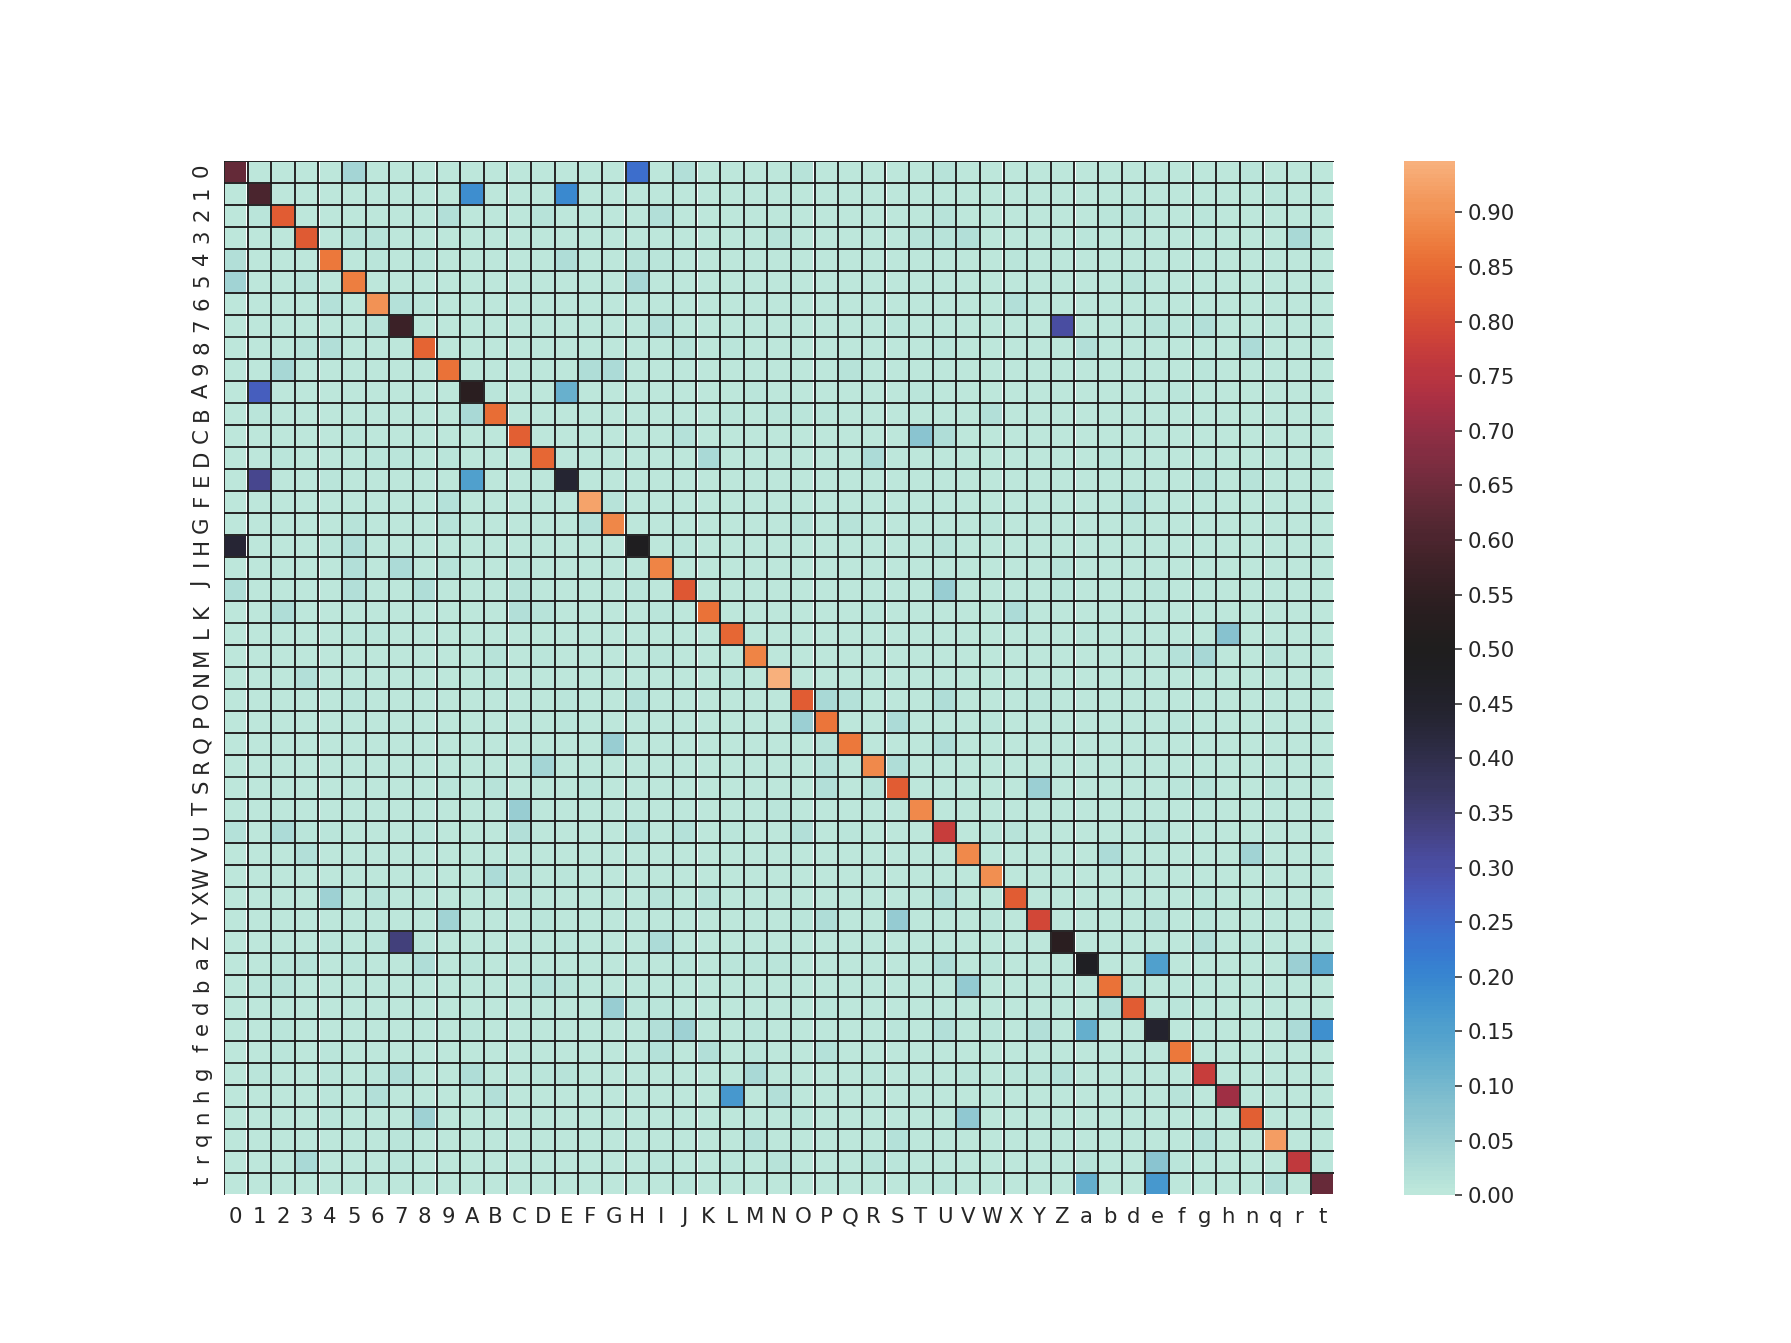

In [14]:
mpl.rcParams['figure.figsize'] = 20,15
heat_map_df = pd.DataFrame(heat_map_data/heat_map_data.sum(axis=1,  keepdims = True), columns = [labels_map[i] for i in range(47)], 
                           index = [labels_map[i] for i in range(47)] )
#sb.palplot(sb.diverging_palette(200, 100, n=47)) cmap="cubehelix" 
ax = sb.heatmap(heat_map_df, annot=False, cbar=True,cbar_kws={"ticks":[0.05*i for i in range(21)]},
            linewidth=1.0, center=0.5)
sb.set(font_scale=1.5)
ax.hlines([range(47)], *ax.get_xlim())
ax.vlines([range(47)], *ax.get_xlim())
plt.savefig('../outputs/journal_resubmit/heatmap_spikeprop_rndm_floats.pdf',bbox_inches='tight')
plt.savefig('../outputs/journal_resubmit/heatmap_spikeprop_rndm_floats.png',bbox_inches='tight')
plt.savefig('../outputs/journal_resubmit/heatmap_spikeprop_rndm_floats.eps',bbox_inches='tight')
plt.show()
del ax

<IPython.core.display.Javascript object>


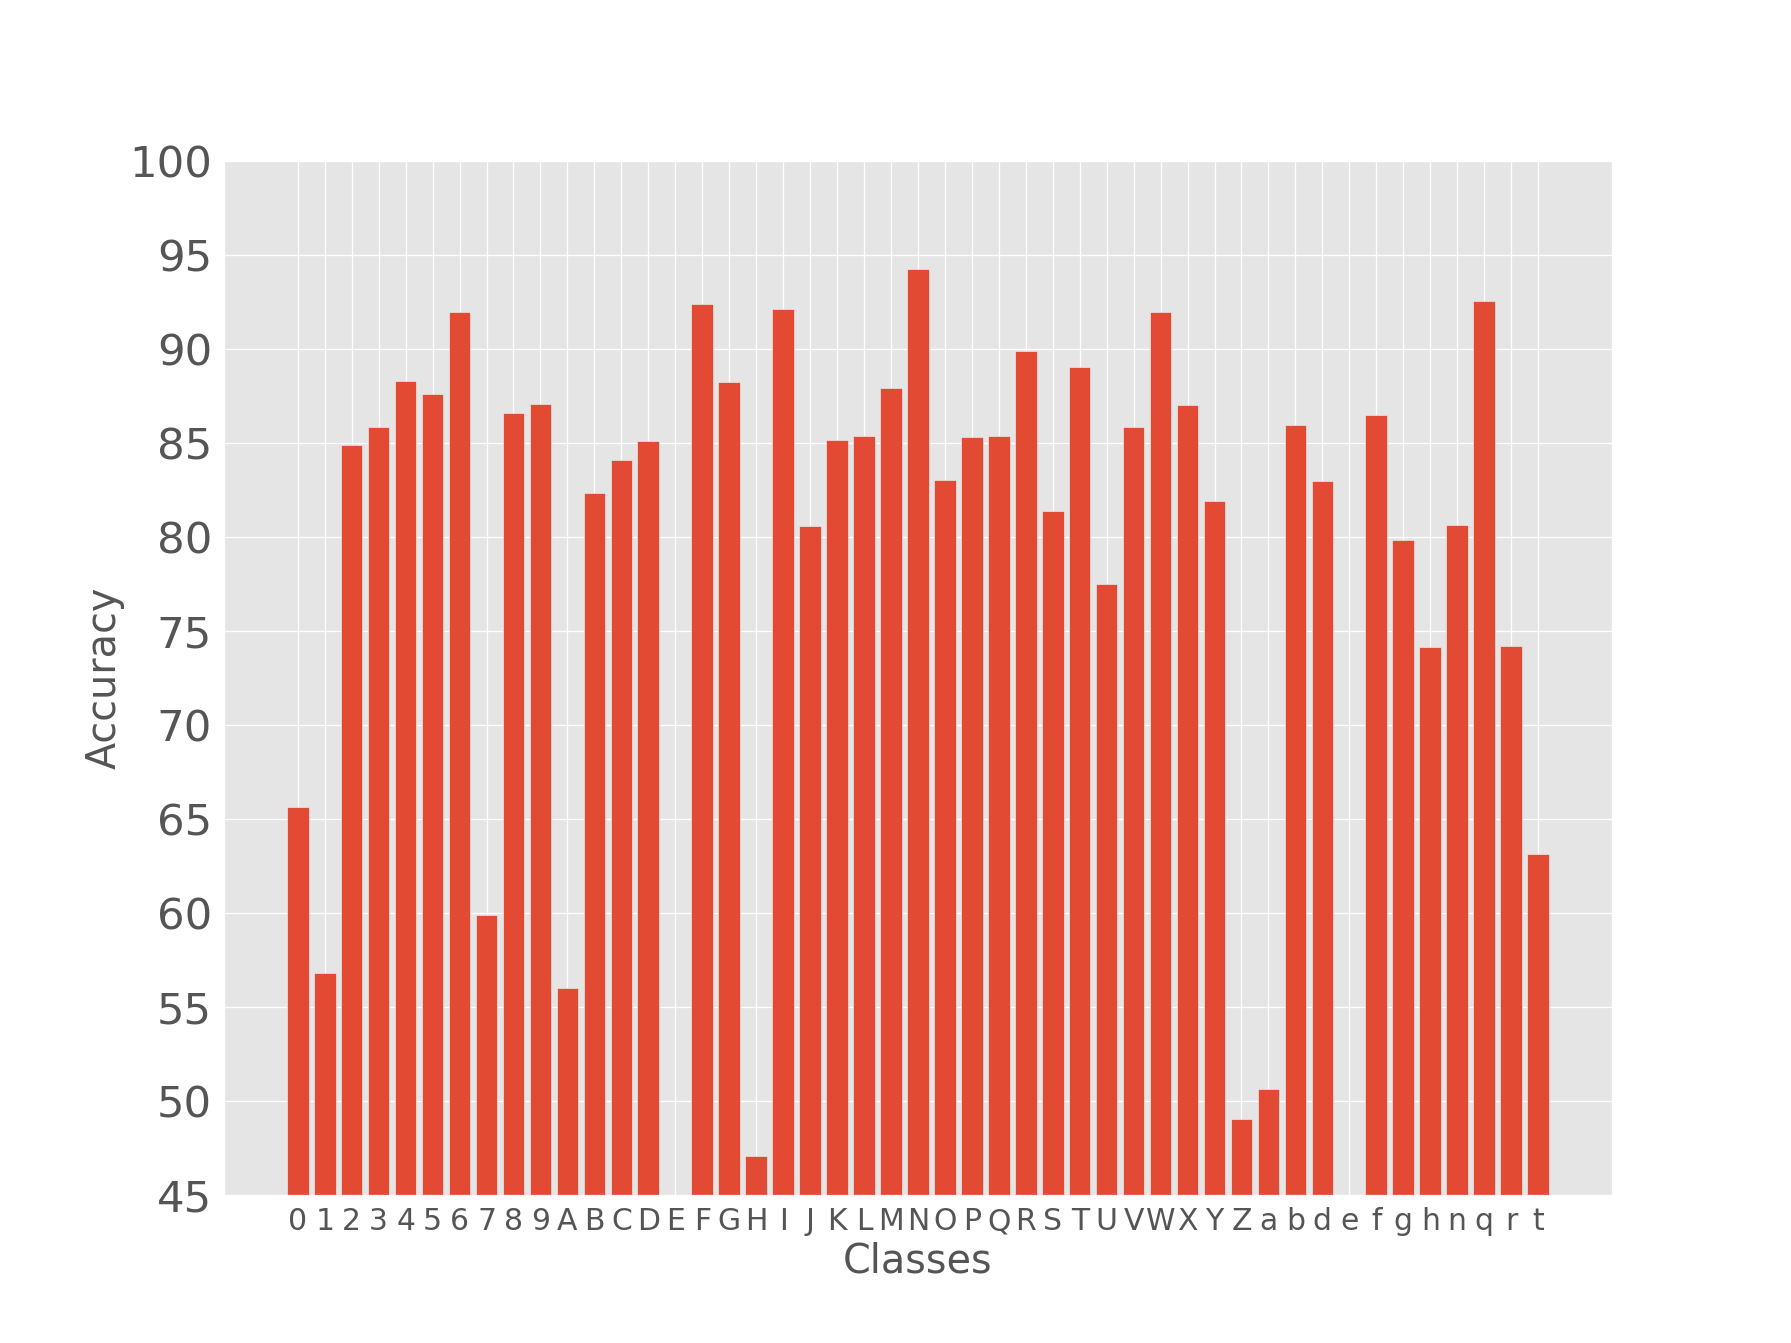

In [15]:
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 20,15
classwise_accuracy = 100*np.array(correct_classifications_per_class)/np.array(samples_per_class)
plt.bar(range(len(classwise_accuracy)), classwise_accuracy)
#plt.grid(b=True, which='major', color='k', linestyle='-',alpha=0.0)
plt.grid(b=True, which='minor', color='w', linestyle='-', alpha=1.0)
plt.xlabel('Classes',fontsize=32)
plt.ylabel('Accuracy',fontsize=32)
#plt.xlim(-0.5,len(classwise_accuracy))
plt.yticks([5*i for i in range(21)],fontsize=35)
#plt.yscale('log')
plt.xticks(range(47),[labels_map[i] for i in range(47)],fontsize=24)
plt.ylim(45,100.0)
plt.savefig('../outputs/journal_resubmit/acc_per_class_spikeprop_rndm_floats.pdf',bbox_inches='tight')
plt.savefig('../outputs/journal_resubmit/acc_per_class_spikeprop_rndm_floats.png',bbox_inches='tight')
plt.savefig('../outputs/journal_resubmit/acc_per_class_spikeprop_rndm_floats.eps',bbox_inches='tight')
plt.show()


In [16]:
print('Accuracy on numbers:{}'.format(classwise_accuracy[0:10].mean()))

Accuracy on numbers:79.4641198727


In [17]:
labels_map = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',
              16:'G',17:'H',18:'I',19:'J',20:'K',21:'L',22:'M',23:'N',24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',30:'U',
             31:'V',32:'W',33:'X',34:'Y',35:'Z',36:'a',37:'b',38:'d',39:'e',40:'f',41:'g',42:'h',43:'n',44:'q',45:'r',
             46:'t'}

* Evaluate predicted labels and actual labels

In [18]:
predicted_labels = []
actual_labels = []
for index in range(len(wrong_classify_indices)):
    #inspct_right_wrong = 'wrong'
    #if(inspct_right_wrong == 'right'):
    #    sample_2_inspect = right_classify_indices[index]
    #else:
    sample_2_inspect = wrong_classify_indices[index]
    
    actual_label = np.argmax(emnist_valid_labels[sample_2_inspect])
    actual_labels.append(labels_map[actual_label])
    #print('Actual label:{}'.format(actual_label))
    #if(inspct_right_wrong == 'right'):
    #    print('Predicted label:{}'.format(right_predict_labels[index]))
    #else:
    predicted_label = wrong_predict_labels[index]
    predicted_labels.append(labels_map[predicted_label])
    #print('Predicted label:{}'.format(predicted_label))
    #print('Actual Image')
    #plt.imshow()
    #plt.show()


* Plot the predicted and actual labels with images

In [19]:
print(predicted_labels[0:4])
print(actual_labels[0:4])

['b', 'A', 'P', '0']
['F', 'E', 'E', 'O']


### Accuracy with conditioning
* In this section we will condition the labels predict the label given that the actual label is a numeric or an upper case alphabet or a lower case alphabet

In [33]:
original_valid_labels_scalar = emnist_valid_labels.argmax(axis=1)
original_test_labels_scalar = emnist_test_labels.argmax(axis=1)

In [21]:
numerics = list(range(0,10))
upper_cases = list(range(10,36))
lower_cases = list(range(36,47))
print(numerics)
print(upper_cases)
print(lower_cases)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]


* Accuracy of the best validation predictions

In [22]:
req_activations = best_activations

In [23]:
correct_preds = 0
##note that below variables are recorded only for mis matches
conditioned_predicted_labels = []
conditioned_actual_labels = []
conditioned_mis_match_ids = []
samples_per_class = [0]*47
correct_classifications_per_class = [0]*47
heat_map_data = np.array([[[0.0]*47]*47])
heat_map_data = heat_map_data[0]
for i in range(len(original_valid_labels_scalar)):
    true_label = original_valid_labels_scalar[i]
    samples_per_class[true_label]+=1.0
    if(true_label in numerics):
        predicted_label = req_activations[i][numerics].argmax()
        heat_map_data[true_label][predicted_label]+=1.0
        if(true_label == predicted_label):
            correct_classifications_per_class[predicted_label]+=1.0
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            conditioned_mis_match_ids.append(i)
    elif(true_label in upper_cases):
        predicted_label = req_activations[i][upper_cases].argmax() + len(numerics)
        heat_map_data[true_label][predicted_label]+=1.0
        if(true_label == predicted_label):
            correct_classifications_per_class[predicted_label]+=1.0
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            conditioned_mis_match_ids.append(i)
    elif(true_label in lower_cases):
        predicted_label = req_activations[i][lower_cases].argmax() + len(upper_cases) + len(numerics)
        heat_map_data[true_label][predicted_label]+=1.0
        if(true_label == predicted_label):
            correct_classifications_per_class[predicted_label]+=1.0
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            conditioned_mis_match_ids.append(i)
print('Number of mis-matches:{}'.format(len(conditioned_mis_match_ids)))
print('Validation aaccuracy with conditioned labels:{}'.format(float(correct_preds)/len(original_valid_labels_scalar)))

Number of mis-matches:1215
Validation aaccuracy with conditioned labels:0.880307358881


In [24]:
heat_map_df = pd.DataFrame(heat_map_data/heat_map_data.sum(axis=1, keepdims = True), columns = [labels_map[i] for i in range(47)], 
                           index = [labels_map[i] for i in range(47)] )

In [25]:
heat_map_df.head(15)

,0,1,2,3,4,5,6,7,8,9,...,b,d,e,f,g,h,n,q,r,t
0,0.889868,0.000000,0.008811,0.004405,0.017621,0.070485,0.000000,0.000000,0.008811,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.004695,0.967136,0.004695,0.000000,0.009390,0.004695,0.000000,0.009390,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.004310,0.008621,0.935345,0.000000,0.008621,0.012931,0.000000,0.004310,0.004310,0.021552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.004292,0.000000,0.004292,0.952790,0.000000,0.008584,0.017167,0.008584,0.004292,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.018692,0.000000,0.004673,0.000000,0.953271,0.000000,0.014019,0.004673,0.004673,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.098291,0.000000,0.004274,0.008547,0.000000,0.884615,0.000000,0.004274,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.000000,0.000000,0.010050,0.020101,0.000000,0.949749,0.015075,0.005025,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.014493,0.019324,0.004831,0.004831,0.004831,0.014493,0.922705,0.009662,0.004831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.004785,0.000000,0.000000,0.019139,0.043062,0.000000,0.000000,0.009569,0.923445,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000,0.004464,0.031250,0.004464,0.000000,0.000000,0.000000,0.004464,0.000000,0.955357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>


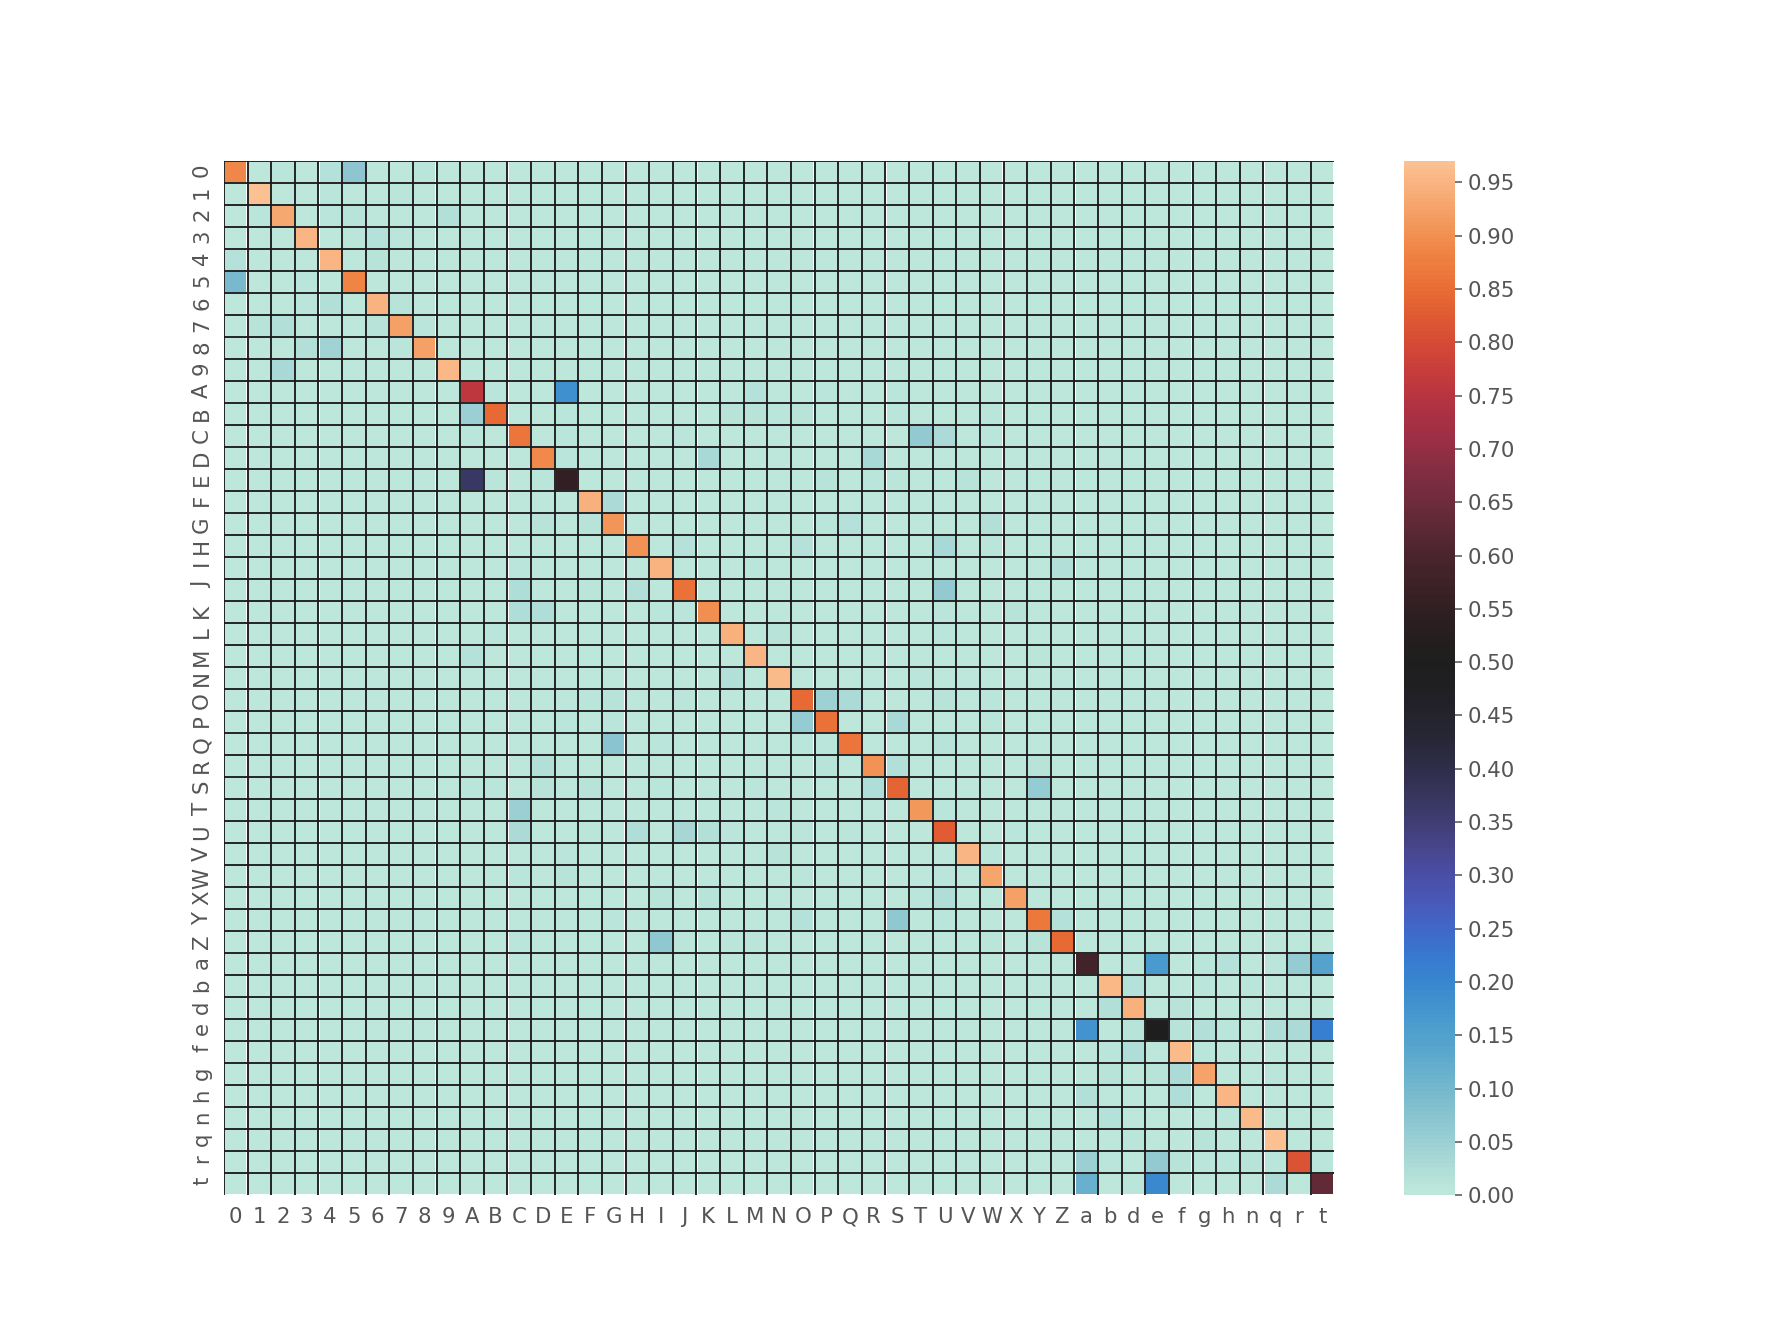

In [26]:
mpl.rcParams['figure.figsize'] = 20,15
#heat_map_df = pd.DataFrame(heat_map_data/heat_map_data.sum(axis=1,  keepdims = True), columns = [labels_map[i] for i in range(47)], 
#                           index = [labels_map[i] for i in range(47)] )
#sb.palplot(sb.diverging_palette(200, 100, n=47)) cmap="cubehelix" 
ax = sb.heatmap(heat_map_df, annot=False, cbar=True,cbar_kws={"ticks":[0.05*i for i in range(21)]},
            linewidth=1.0, center=0.5)
sb.set(font_scale=1.55)
ax.hlines([range(47)], *ax.get_xlim())
ax.vlines([range(47)], *ax.get_xlim())
plt.savefig('../outputs/journal_resubmit/heatmap_cond_spikeprop_rndm_floats.pdf',bbox_inches='tight')
plt.savefig('../outputs/journal_resubmit/heatmap_cond_spikeprop_rndm_floats.png',bbox_inches='tight')
plt.savefig('../outputs/journal_resubmit/heatmap_cond_spikeprop_rndm_floats.eps',bbox_inches='tight')
plt.show()
del ax

In [27]:
print(heat_map_df.loc['q','g'],heat_map_df.loc['q','q'],heat_map_df.loc['g','q'],heat_map_df.loc['g','g'])

(0.014925373134328358, 0.9701492537313433, 0.009174311926605505, 0.926605504587156)


In [28]:
print(heat_map_df.loc['q',:].sum())

1.0


In [29]:
print(heat_map_df.loc['I','L'],heat_map_df.loc['I','I'],heat_map_df.loc['L','I'],heat_map_df.loc['L','L'])

(0.0, 0.9507389162561576, 0.0, 0.9452054794520548)


<IPython.core.display.Javascript object>


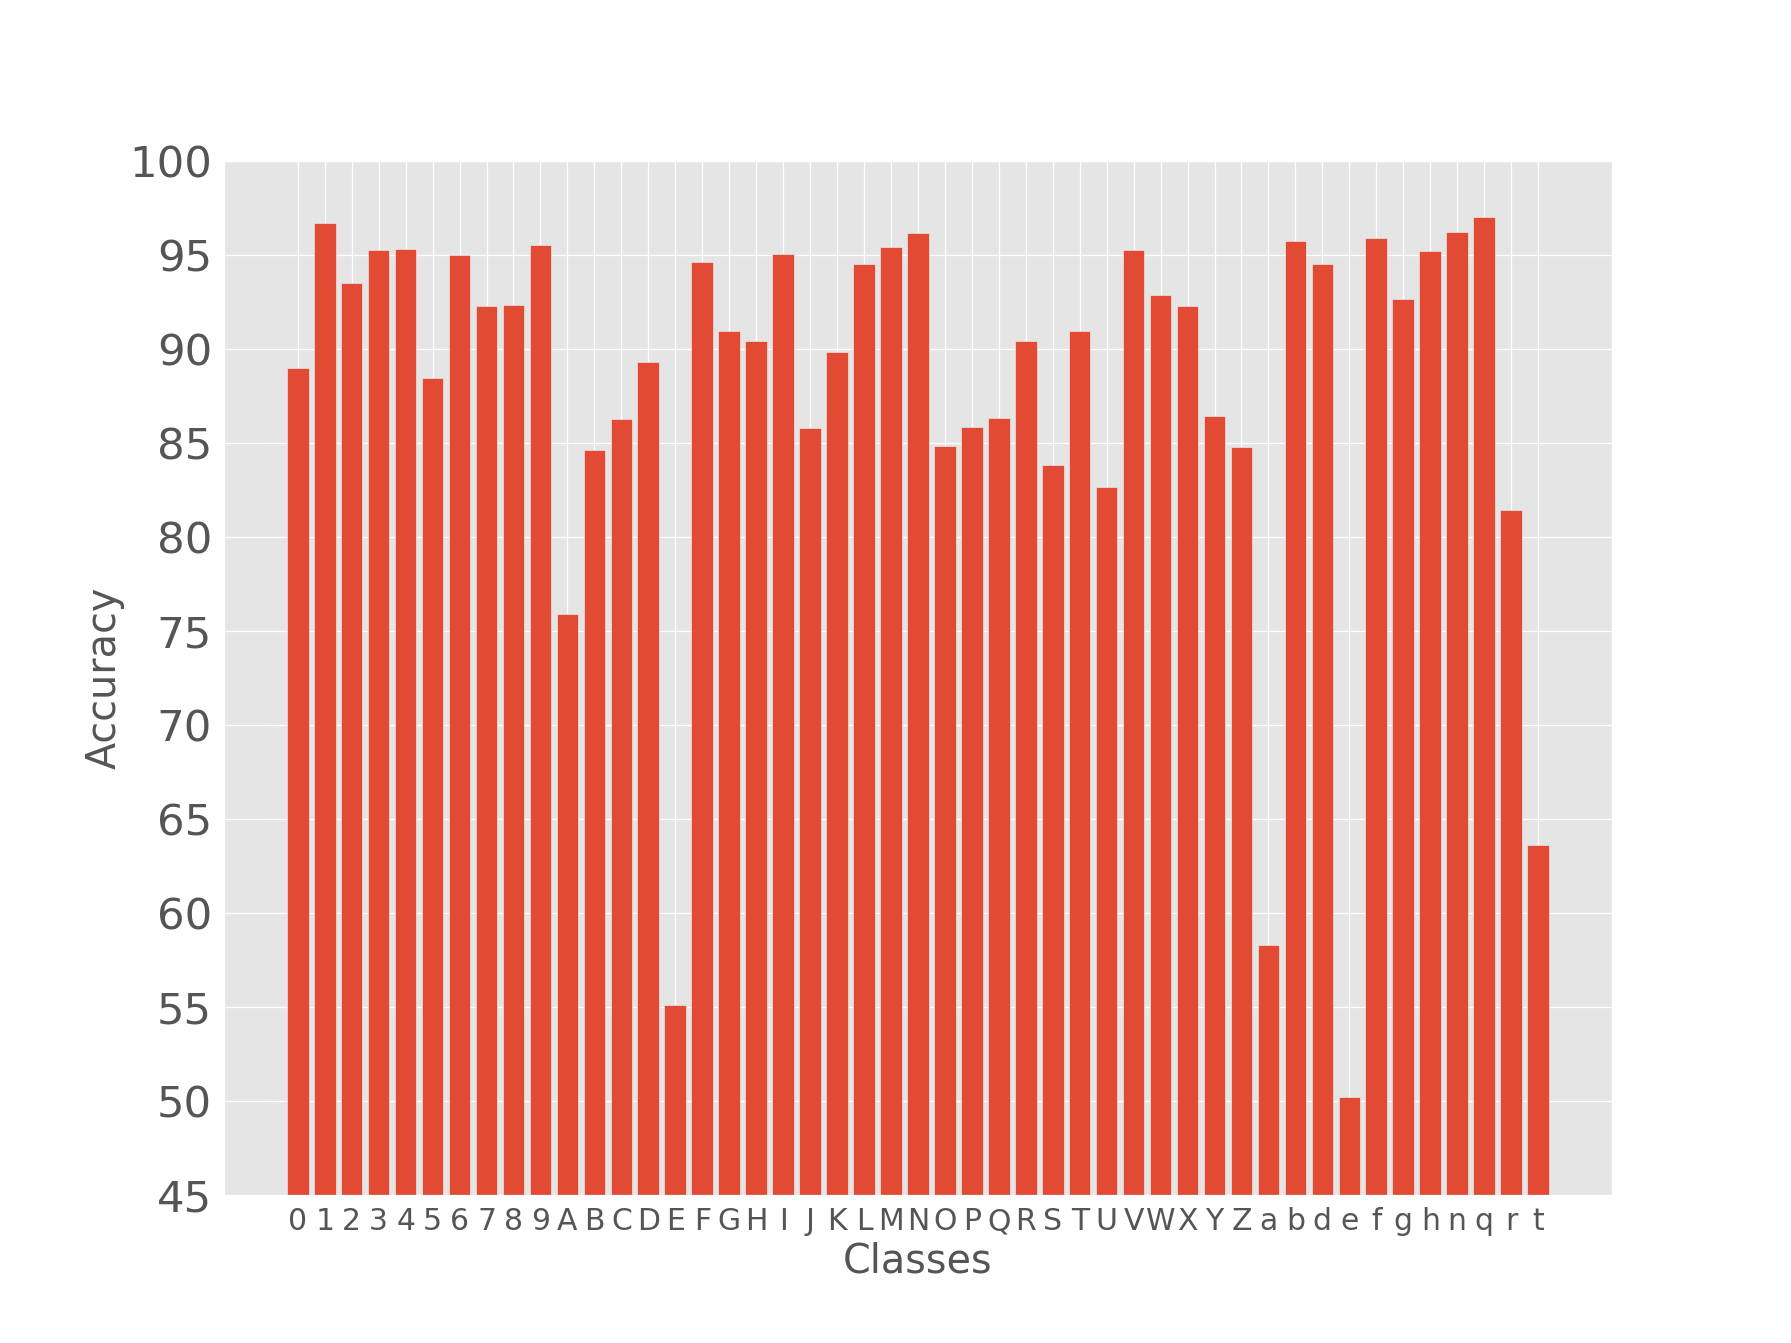

In [30]:
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 20,15
classwise_accuracy = 100*np.array(correct_classifications_per_class)/np.array(samples_per_class)
plt.bar(range(len(classwise_accuracy)), classwise_accuracy)
#plt.grid(b=True, which='major', color='k', linestyle='-',alpha=0.0)
plt.grid(b=True, which='minor', color='w', linestyle='-', alpha=1.0)
plt.xlabel('Classes',fontsize=32)
plt.ylabel('Accuracy',fontsize=32)
#plt.xlim(-0.5,len(classwise_accuracy))
plt.yticks([5*i for i in range(21)],fontsize=35)
#plt.yscale('log')
plt.xticks(range(47),[labels_map[i] for i in range(47)],fontsize=24)
plt.ylim(45,100.0)
plt.savefig('../outputs/journal_resubmit/acc_per_class_cond_spikeprop_rndm_floats.pdf',bbox_inches='tight')
plt.savefig('../outputs/journal_resubmit/acc_per_class_cond_spikeprop_rndm_floats.png',bbox_inches='tight')
plt.savefig('../outputs/journal_resubmit/acc_per_class_cond_spikeprop_rndm_floats.eps',bbox_inches='tight')
plt.show()


###  Accuracy on the best test data with conditioning

In [31]:
req_activations = best_activations_test
#req_activations = activations_test.transpose()

In [34]:
correct_preds = 0
##note that below variables are recorded only for mis matches
conditioned_predicted_labels = []
conditioned_actual_labels = []
conditioned_mis_match_ids = []
conditioned_mis_match_images = []
for i in range(len(original_test_labels_scalar)):
    true_label = original_test_labels_scalar[i]
    if(true_label in numerics):
        predicted_label = req_activations[i][numerics].argmax()
        if(true_label == predicted_label):
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            #conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
    elif(true_label in upper_cases):
        predicted_label = req_activations[i][upper_cases].argmax() + len(numerics)
        if(true_label == predicted_label):
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            #conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
    elif(true_label in lower_cases):
        predicted_label = req_activations[i][lower_cases].argmax() + len(upper_cases) + len(numerics)
        if(true_label == predicted_label):
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            #conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
print('Number of mis-matches:{}'.format(len(conditioned_mis_match_ids)))
print('Accuracy with conditioned labels:{}'.format(float(correct_preds)/len(original_test_labels_scalar)))

Number of mis-matches:2239
Accuracy with conditioned labels:0.880904255319


### Cost, validation and accuracy plots

In [ ]:
plt.plot(train_costs, label="Train Costs")
plt.plot(val_costs, label="Val Costs")
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid(b=True, which='major', color='w', linestyle='-',alpha=1.0)
#plt.grid(b=True, which='minor', color='w', linestyle='-', alpha=1.0)
plt.legend()
plt.show()

In [ ]:
plt.plot(train_accuracies, label="Train accuracies")
plt.plot(val_accuracies, label="Val accuracies")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.01*i for i in range(1,101)])
plt.ylim(0.75,1.02)
plt.grid(b=True, which='major', color='w', linestyle='-',alpha=1.0)
plt.legend()
plt.show()

path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/'
writer = tf.summary.FileWriter(path, sess.graph)
writer.flush()
tl = timeline.Timeline(run_metadata.step_stats)
ctf = tl.generate_chrome_trace_format()
with open(path+'/timeline.json', 'w') as f:
    f.write(ctf)


writer.add_run_metadata(run_metadata, 'mysess')
writer.flush()
writer.close()